In [1]:
import os
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from gym import utils
import gym
import pickle

### MLens Dataset Loading & Preparation

In [2]:
# Loading the MovieLens dataset
ML_LATEST_SMALL_DATA_ROOT_PATH = "/home/ssk/Desktop/Master Thesis/code/mlp-master-thesis-personalization-main/data/dt-datasets/movielens/ml-latest-small"
ML_LATEST_DATA_ROOT_PATH = "/home/ssk/Desktop/Master Thesis/code/mlp-master-thesis-personalization-main/data/dt-datasets/movielens/ml-latest"

##### Load the ML-latest-small dataset

In [3]:
links_df = pd.read_csv(os.path.join(ML_LATEST_SMALL_DATA_ROOT_PATH, "links.csv"))
movies_df = pd.read_csv(os.path.join(ML_LATEST_SMALL_DATA_ROOT_PATH, "movies.csv"))
ratings_df = pd.read_csv(os.path.join(ML_LATEST_SMALL_DATA_ROOT_PATH, "ratings.csv"))
tags_df = pd.read_csv(os.path.join(ML_LATEST_SMALL_DATA_ROOT_PATH, "tags.csv"))
print(f"links shape: {links_df.shape}\nmovies shape: {movies_df.shape}\nratings shape: {ratings_df.shape}\ntags shape: {tags_df.shape}")

links shape: (9742, 3)
movies shape: (9742, 3)
ratings shape: (100836, 4)
tags shape: (3683, 4)


##### Load the ML-latest-full dataset

In [4]:
links_25m_df = pd.read_csv(os.path.join(ML_LATEST_DATA_ROOT_PATH, "links.csv"))
movies_25m_df = pd.read_csv(os.path.join(ML_LATEST_DATA_ROOT_PATH, "movies.csv"))
ratings_25m_df = pd.read_csv(os.path.join(ML_LATEST_DATA_ROOT_PATH, "ratings.csv"))
tags_25m_df = pd.read_csv(os.path.join(ML_LATEST_DATA_ROOT_PATH, "tags.csv"))
print(f"links shape: {links_25m_df.shape}\nmovies shape: {movies_25m_df.shape}\nratings shape: {ratings_25m_df.shape}\ntags shape: {tags_25m_df.shape}")

links shape: (86537, 3)
movies shape: (86537, 3)
ratings shape: (33832162, 4)
tags shape: (2328315, 4)


min no of rating: 20, max no of rating: 2698
average rating per user: 165.30491803278687, median rating per user: 70.5
number of users who rated less than 140 movies: 429


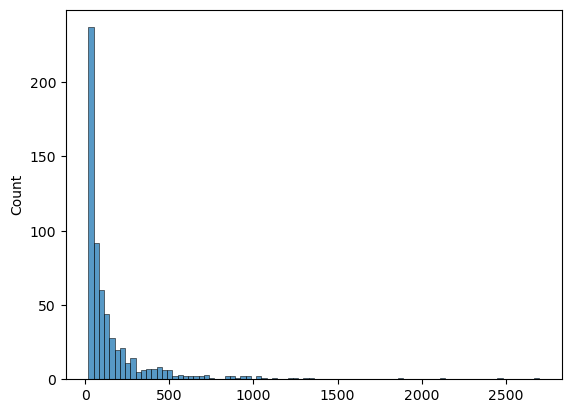

In [5]:
# Data distribution of the rating count per user in the small dataset
rating_count_per_user = ratings_df.groupby('userId')['movieId'].count().values
print(f'min no of rating: {np.min(rating_count_per_user)}, max no of rating: {np.max(rating_count_per_user)}')
print(f'average rating per user: {np.mean(rating_count_per_user)}, median rating per user: {np.median(rating_count_per_user)}')
print(f'number of users who rated less than 140 movies: {(rating_count_per_user <= 140).sum()}')
sns.histplot(data = rating_count_per_user)
plt.show()
# sns.boxplot(rating_count_per_user)

min no of rating: 1, max no of rating: 33332
average rating per user: 102.21969030893572, median rating per user: 31.0
number of users who rated less than 140 movies: 270870 which is 81.84001812825741% of the users.


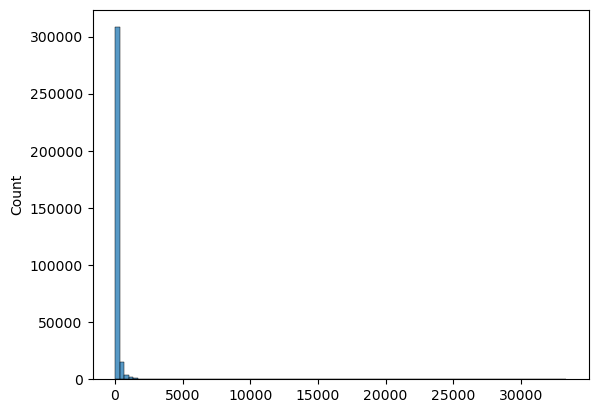

In [6]:
# Data distribution of the rating count per user in the small dataset
rating_count_per_user = ratings_25m_df.groupby('userId')['movieId'].count().values
print(f'min no of rating: {np.min(rating_count_per_user)}, max no of rating: {np.max(rating_count_per_user)}')
print(f'average rating per user: {np.mean(rating_count_per_user)}, median rating per user: {np.median(rating_count_per_user)}')

rating_count_less_than_140 = (rating_count_per_user <= 140).sum()
print(f'number of users who rated less than 140 movies: {rating_count_less_than_140} which is {(rating_count_less_than_140 / ratings_25m_df.userId.unique().shape[0]) * 100}% of the users.')
sns.histplot(data = rating_count_per_user, bins=100)
plt.show()
# sns.boxplot(rating_count_per_user)

##### Prepare the movies_df

In [7]:
print(movies_df['title'].unique().shape[0])

# Find the duplicated movie titles
duplicated_movies = movies_df[movies_df['title'].duplicated(keep=False)].sort_values(by=['title', 'movieId'])

# Some movies have additional genres, that's why the duplicates
# Merge the genres, keep the ID of the one that has the highest number
# of genres, create a map of the old and new id
# drop the row with the least genre after merging
duplicated_movie_titles = duplicated_movies['title'].unique()
movie_ids_to_remove = duplicated_movies['movieId'].values
movie_indices_to_remove = duplicated_movies.index.values
id_mapping = {}
resolved_movies = []
for title in duplicated_movie_titles:
    movie_ids = duplicated_movies[duplicated_movies['title'] == title]['movieId'].values
    genre_groups = duplicated_movies[duplicated_movies['title'] == title]['genres'].values

    for i in range(1, len(movie_ids)):
        id_mapping[movie_ids[i]] = movie_ids[0]
    merged_genres = set()
    for genre_grp in genre_groups:
        genres = genre_grp.split('|')
        merged_genres = merged_genres.union(set(genres))
    merged_genres = list(merged_genres)
    genres_mixed = ""
    for (i, g) in enumerate(merged_genres):
        if i != len(merged_genres)-1:
            genres_mixed += g + "|"
        else:
            genres_mixed += g

    resolved_movies.append({'movieId': movie_ids[0], 'title': title, 'genres': genres_mixed})

pd.DataFrame(resolved_movies)


9737


,movieId,title,genres
0,6003,Confessions of a Dangerous Mind (2002),Thriller|Crime|Romance|Comedy|Drama
1,838,Emma (1996),Comedy|Drama|Romance
2,32600,Eros (2004),Drama|Romance
3,2851,Saturn 3 (1980),Adventure|Thriller|Sci-Fi
4,34048,War of the Worlds (2005),Action|Adventure|Thriller|Sci-Fi


In [8]:
# Now remove the duplicate movies from the movies_df
print(f"Shape before rmeoving: {movies_df.shape}")
movies_df = movies_df.drop(movie_indices_to_remove)
print(f"Shape after rmeoving: {movies_df.shape}")

Shape before rmeoving: (9742, 3)
Shape after rmeoving: (9732, 3)


In [9]:
# Now concatenate the movies_df with removed movies and the merged_genres movies
movies_df = pd.concat([movies_df, pd.DataFrame(resolved_movies)], ignore_index=True)
print(movies_df.shape)

(9737, 3)


##### Prepare the ratings_df

In [10]:
# Now we have to replace the removed movie ids in the ratings_df
# and also in the tags_df
ratings_df.head()
ratings_df_copy = ratings_df.copy()

In [11]:
# Replace the ids with the id_mapping
ratings_df_copy['movieId'] = ratings_df_copy['movieId'].replace(id_mapping)

In [12]:
# See the duplicates
ratings_df_copy[ratings_df_copy[['userId', 'movieId']].duplicated(keep=False)]

,userId,movieId,rating,timestamp
4590,28,34048,3.5,1234516420
4747,28,34048,3.5,1234850075
11241,68,34048,2.0,1158532246
11451,68,34048,2.5,1230497715
17449,111,6003,4.0,1516468531
17819,111,6003,4.0,1517441257
80405,509,838,3.5,1436031723
80596,509,838,3.5,1436031753


In [13]:
ratings_df_copy = ratings_df_copy.drop_duplicates(['userId', 'movieId', 'rating'])

In [14]:
# Only one movie with two different ratings from the same user
ratings_df_copy[ratings_df_copy[['userId', 'movieId']].duplicated(keep=False)]

,userId,movieId,rating,timestamp
11241,68,34048,2.0,1158532246
11451,68,34048,2.5,1230497715


In [15]:
# We will drop the one with the lowest rating
ratings_df = ratings_df_copy.drop([11241])
ratings_df.shape

(100832, 4)

In [16]:
# no more duplicates
ratings_df[ratings_df[['userId', 'movieId']].duplicated(keep=False)]

,userId,movieId,rating,timestamp


##### Prepare the tags_df

In [17]:
# Now we have to replace the removed movie ids in the tags_df
tags_df_copy = tags_df.copy()
tags_df_copy.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [18]:
# Replace the ids first with the id_mapping
tags_df_copy['movieId'] = tags_df_copy['movieId'].replace(id_mapping)

In [19]:
# See the duplicates
tags_df_copy[tags_df_copy[['userId', 'movieId']].duplicated(keep=False)]

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200
...,...,...,...,...
3669,599,2959,twist ending,1498456888
3670,599,2959,violence,1498456904
3671,599,2959,violent,1498456914
3680,610,3265,gun fu,1493843984


In [20]:
# Results suggest that there are some outliers in the dataset
tags_df_copy.groupby(['userId'])['movieId'].count().mean(), tags_df_copy.groupby(['userId'])['movieId'].count().median()

(63.5, 4.0)

In [21]:
# Average number of tags per user per movie
tags_df_copy.groupby(['userId', 'movieId']).count()['tag'].mean()

2.074929577464789

In [22]:
# Outlier: user 599 provided 173 tags for the movie 296
print(f"name of the movie: {movies_df[movies_df['movieId'] == 296]['title'].values[0]}")
tags_df[(tags_df['userId'] == 599) & (tags_df['movieId'] == 296)].sort_values(by='timestamp')

name of the movie: Pulp Fiction (1994)


,userId,movieId,tag,timestamp
3512,599,296,Quentin Tarantino,1498456338
3425,599,296,dark comedy,1498456339
3495,599,296,nonlinear,1498456341
3528,599,296,Samuel L. Jackson,1498456342
3490,599,296,multiple storylines,1498456343
...,...,...,...,...
3526,599,296,Roger Avary,1498456682
3460,599,296,Harvey Keitel,1498456684
3445,599,296,foul language,1498456686
3506,599,296,Palme d'Or,1498456690


##### Merge the tags

In [23]:
tags_df['tag'] = tags_df['tag'].str.lower()

# Grouping by 'movieId' and 'userId' and aggregating tags
tags_df_merged = tags_df.groupby(['movieId', 'userId'])['tag'].agg(lambda x: '|'.join(x)).reset_index()
tags_df_merged

,movieId,userId,tag
0,1,336,pixar
1,1,474,pixar
2,1,567,fun
3,2,62,fantasy|magic board game|robin williams
4,2,474,game
...,...,...,...
1770,183611,62,comedy|funny|rachel mcadams
1771,184471,62,adventure|alicia vikander|video game adaptation
1772,187593,62,josh brolin|ryan reynolds|sarcasm
1773,187595,62,emilia clarke|star wars


##### Merge the movies and ratings dataframes together

In [24]:
movies_and_ratings = pd.merge(movies_df, ratings_df, on='movieId')
movies_and_ratings.shape

(100832, 6)

In [25]:
movies_and_ratings.head()

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.5,1106635946
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.5,1510577970
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17,4.5,1305696483


In [26]:
# Check if there is any duplicate
print(movies_and_ratings.duplicated().sum())

print(movies_and_ratings.isna().sum())
movies_and_ratings[movies_and_ratings[['movieId', 'userId']].duplicated(keep=False)]

0
movieId      0
title        0
genres       0
userId       0
rating       0
timestamp    0
dtype: int64


,movieId,title,genres,userId,rating,timestamp


In [27]:
movies_and_ratings.dtypes

movieId        int64
title         object
genres        object
userId         int64
rating       float64
timestamp      int64
dtype: object

In [28]:
# Check if there are any null values
movies_and_ratings['userId'].isna().sum(),  movies_and_ratings['movieId'].isna().sum()

(0, 0)

In [29]:
# Check if all the userIds are present in the merged df as well
sorted(ratings_df.userId.unique()) ==  sorted(movies_and_ratings.userId.unique())

True

In [30]:
# Sort the movie ratings by userId and timestamp in an ascending manner
movies_and_ratings = movies_and_ratings.sort_values(by=['userId', 'timestamp'])
movies_and_ratings.head()

,movieId,title,genres,userId,rating,timestamp
19452,804,She's the One (1996),Comedy|Romance,1,4.0,964980499
25835,1210,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Sci-Fi,1,5.0,964980499
38331,2018,Bambi (1942),Animation|Children|Drama,1,5.0,964980523
45777,2628,Star Wars: Episode I - The Phantom Menace (1999),Action|Adventure|Sci-Fi,1,4.0,964980523
48477,2826,"13th Warrior, The (1999)",Action|Adventure|Fantasy,1,4.0,964980523


In [31]:
# Find out the different rating values
sorted(movies_and_ratings['rating'].unique())

[0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]

In [32]:
# Another reward scheme
highest_rating = 5.0
movies_and_ratings['reward'] = (1 - abs(movies_and_ratings['rating'] - highest_rating) / 4.5) ** 2

##### Merge the movies and ratings dataframes together with the tags dataframe

In [33]:
movie_ids_set = set(movies_and_ratings['movieId'].tolist())


In [34]:
movie_ids_set_from_tags_df = set(tags_df['movieId'].tolist())
len(movie_ids_set_from_tags_df)

1572

In [35]:
len(movie_ids_set_from_tags_df.difference(movie_ids_set.intersection(movie_ids_set_from_tags_df)))

18

In [36]:
movies_ratings_and_tags = pd.merge(movies_and_ratings, tags_df_merged, on=['movieId', 'userId'], how='left')
movies_ratings_and_tags['tag'].isna().sum()

99197

#### How many different genres do we have?

In [37]:
np.unique(np.concatenate(movies_and_ratings['genres'].apply(lambda g: g.split("|")).tolist()))


array(['(no genres listed)', 'Action', 'Adventure', 'Animation',
       'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
       'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance',
       'Sci-Fi', 'Thriller', 'War', 'Western'], dtype='<U18')

In [38]:
all_genres = movies_and_ratings['genres']

### Produce the embeddings

#### Using BERT: <a>https://colab.research.google.com/drive/1ea3zDFrCQFQhkvinaQfdbvXlOhR7hw01?usp=sharing#scrollTo=pqYxJi28X63W</a>

In [39]:
from transformers import BertModel, BertTokenizer
import torch
from collections import OrderedDict

In [40]:
model = BertModel.from_pretrained('bert-base-uncased',
           output_hidden_states = True,)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

#### Using GPT2

In [41]:
# from transformers import GPT2TokenizerFast, GPT2LMHeadModel, GPT2Tokenizer
# model = GPT2LMHeadModel.from_pretrained('gpt2')
# word_embeddings = model.transformer.wte.weight # Word Token Embeddings
# position_embeddings = model.transformer.wpe.weight  # Word Position Embeddings
# tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

In [42]:
groups = tags_df.groupby(['userId', 'movieId'])

#### Embedding the movie titles, genres and the tags

In [43]:
# With BERT

def bert_text_preparation(text, tokenizer):
  """
  Preprocesses text input in a way that BERT can interpret.
  """
  marked_text = "[CLS] " + text + " [SEP]"
  tokenized_text = tokenizer.tokenize(marked_text)
  indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
  segments_ids = [1]*len(indexed_tokens)

  # convert inputs to tensors
  tokens_tensor = torch.tensor([indexed_tokens])
  segments_tensor = torch.tensor([segments_ids])

  return tokenized_text, tokens_tensor, segments_tensor

def get_bert_embeddings(tokens_tensor, segments_tensor, model):
    """
    Obtains BERT embeddings for tokens, in context of the given sentence.
    """
    # gradient calculation id disabled
    with torch.no_grad():
      # obtain hidden states
      outputs = model(tokens_tensor, segments_tensor)
      hidden_states = outputs[2]

    # concatenate the tensors for all layers
    # use "stack" to create new dimension in tensor
    token_embeddings = torch.stack(hidden_states, dim=0)

    # remove dimension 1, the "batches"
    token_embeddings = torch.squeeze(token_embeddings, dim=1)

    # swap dimensions 0 and 1 so we can loop over tokens
    token_embeddings = token_embeddings.permute(1,0,2)

    # intialized list to store embeddings
    token_vecs_sum = []

    # "token_embeddings" is a [Y x 12 x 768] tensor
    # where Y is the number of tokens in the sentence

    # loop over tokens in sentence
    for token in token_embeddings:

        # "token" is a [12 x 768] tensor

        # sum the vectors from the last four layers
        sum_vec = torch.sum(token[-4:], dim=0)
        token_vecs_sum.append(sum_vec)
        # token_vecs_sum_tensor = torch.stack(token_vecs_sum)
        # token_embedding = torch.sum(token_vecs_sum_tensor, dim=0)

    # return token_embedding
    return token_vecs_sum

In [44]:
def merge_embeddings(tokenized_text, list_token_embeddings):
    context_embeddings = []
    context_tokens = []
    # make ordered dictionary to keep track of the position of each word
    tokens = OrderedDict()

    # loop over tokens in sensitive sentence
    for token in tokenized_text[1:-1]:
        # keep track of position of word and whether it occurs multiple times
        if token in tokens:
            tokens[token] += 1
        else:
            tokens[token] = 1

        # compute the position of the current token
        token_indices = [i for i, t in enumerate(tokenized_text) if t == token]
        current_index = token_indices[tokens[token]-1]

        # get the corresponding embedding
        token_vec = list_token_embeddings[current_index]
        # save values
        context_tokens.append(token)
        context_embeddings.append(token_vec)
    context_embeddings_tensor = torch.stack(context_embeddings)
    merged_embedding = torch.sum(context_embeddings_tensor, dim=0)

    # print(f"context_embeddings_tensor.shape: {context_embeddings_tensor.shape}")
    return np.array(merged_embedding)

In [45]:
movies_ratings_and_tags['tag'].fillna('NA', inplace=True)

In [46]:
# For BERT
# Embed a movie title
def embed_movie_title(title):
    tokenized_text, tokens_tensor, segments_tensors = bert_text_preparation(title, tokenizer)
    list_token_embeddings = get_bert_embeddings(tokens_tensor, segments_tensors, model)
    title_embedding = merge_embeddings(tokenized_text, list_token_embeddings)
    return title_embedding

# Embed the movie genres and produce an evrage embedding vector
def embed_movie_genres(genres):
    tokenized_text, tokens_tensor, segments_tensors = bert_text_preparation(genres.replace("|", " "), tokenizer)
    list_token_embeddings = get_bert_embeddings(tokens_tensor, segments_tensors, model)
    genres_embedding = merge_embeddings(tokenized_text, list_token_embeddings)
    return genres_embedding

def embed_movie_tags(tags):
    tokenized_text, tokens_tensor, segments_tensors = bert_text_preparation(tags.replace("|", " "), tokenizer)
    list_token_embeddings = get_bert_embeddings(tokens_tensor, segments_tensors, model)
    tags_embedding = merge_embeddings(tokenized_text, list_token_embeddings)
    return tags_embedding

# # Embed the userId
# def embed_userid(user_id):
#     embedding = nn.Embedding(num_users, embedding_dim)
#     genres_embedding = merge_embeddings(tokenized_text, list_token_embeddings)
#     return genres_embedding

In [47]:
# # For GPT2
# # Embed a movie title
# def embed_movie_title(title):
#     text_index = tokenizer.encode(title, add_prefix_space=True)
#     vector = model.transformer.wte.weight[text_index,:]
#     return np.average(vector.detach().numpy(), axis=0)

# # Embed the movie genres and produce an evrage embedding vector
# def embed_movie_genres(genres):
#     text_index = tokenizer.encode(genres.split('|'), add_prefix_space=True)
#     vector = model.transformer.wte.weight[text_index,:]
#     return np.average(vector.detach().numpy(), axis=0)

In [48]:
# # Introduce reward
# # DO NOT DELETE THIS CELL 
# movies_and_ratings['reward'] = 1
# movies_and_ratings

In [49]:
def summation_based_merging():
    pass
def concatenation_based_merging(embedding_list):
    embedding_arr_list = []
    for embed in embedding_list:
        with torch.no_grad():
            embedding_arr_list.append(np.vstack(embed.values))
    merged_embeddings = np.concatenate(embedding_arr_list, axis=1)
    return merged_embeddings

In [50]:
# # Now produce the embeddings
# from tqdm import tqdm
# groups = movies_and_ratings.groupby('userId')
# actions = np.arange(0.5, 5.5, 0.5)

# custom_act_to_orig_act = {idx: action for idx, action in enumerate(actions)}
# orig_act_to_custom_act = {action: idx for idx, action in enumerate(actions)}

# group_list = []
# train_trajectories, test_trajectories = [], []

# user_id_embedder = torch.nn.Embedding(610, 32)

# for group_id, group_df in tqdm(groups):
#    # group_list.append(group_df)
#    rewards = group_df['reward'].tolist()
#    user_id = group_df['userId'].unique()[0]
   
#    raw_observations = group_df.drop(['movieId', 'rating', 'timestamp', 'reward'], axis=1)

#    titles_embeddings = raw_observations['title'].apply(lambda x: embed_movie_title(x))
#    genres_embeddings = raw_observations['genres'].apply(lambda x: embed_movie_genres(x))
#    user_id_embeddings = raw_observations['userId'].apply(lambda x: user_id_embedder(torch.LongTensor([x-1])))


#    titles_embeds_arr = np.vstack(titles_embeddings.values)
#    genres_embeds_arr = np.vstack(genres_embeddings.values)

#    with torch.no_grad():
#       user_id_embeds_arr = np.vstack(user_id_embeddings.values)
   
#    observations = np.concatenate((titles_embeds_arr, genres_embeds_arr, user_id_embeds_arr), axis=1)

#    features = raw_observations.columns
#    targets = group_df['rating'].tolist()
#    # observations = observations.values.tolist()
#    actions = [orig_act_to_custom_act[temp] for temp in targets]

#    next_observations = observations
   
#    terminals = [False]*(len(observations)-1) + [True]
#    trajectory = {
#       'observations': observations,
#       'next_observations': next_observations,
#       'actions': np.array(actions),
#       'rewards': np.array(rewards),
#       'terminals': np.array(terminals),
#       'features': np.array(features),
#       'targets': np.array(targets),
#       'user_id': user_id,
#    }
#    train_trajectories.append(trajectory)
   

In [51]:
movies_ratings_and_tags.head()

,movieId,title,genres,userId,rating,timestamp,reward,tag
0,804,She's the One (1996),Comedy|Romance,1,4.0,964980499,0.604938,NA
1,1210,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Sci-Fi,1,5.0,964980499,1.000000,NA
2,2018,Bambi (1942),Animation|Children|Drama,1,5.0,964980523,1.000000,NA
3,2628,Star Wars: Episode I - The Phantom Menace (1999),Action|Adventure|Sci-Fi,1,4.0,964980523,0.604938,NA
4,2826,"13th Warrior, The (1999)",Action|Adventure|Fantasy,1,4.0,964980523,0.604938,NA


In [52]:
# Now produce the embeddings
from tqdm import tqdm
groups = movies_ratings_and_tags.groupby('userId')
actions = np.arange(0.5, 5.5, 0.5)

custom_act_to_orig_act = {idx: action for idx, action in enumerate(actions)}
orig_act_to_custom_act = {action: idx for idx, action in enumerate(actions)}

group_list = []
all_trajectories, test_trajectories = [], []

user_id_embedder = torch.nn.Embedding(610, 32)

for group_id, group_df in tqdm(groups):
   # group_list.append(group_df)
   rewards = group_df['reward'].tolist()
   user_id = group_df['userId'].unique()[0]
   
   raw_observations = group_df.drop(['movieId', 'rating', 'timestamp', 'reward'], axis=1)

   titles_embeddings = raw_observations['title'].apply(lambda x: embed_movie_title(x))
   genres_embeddings = raw_observations['genres'].apply(lambda x: embed_movie_genres(x))
   tags_embeddings = raw_observations['tag'].apply(lambda x: embed_movie_tags(x))

   user_id_embeddings = raw_observations['userId'].apply(lambda x: user_id_embedder(torch.LongTensor([x-1])))

   titles_and_genres_embeddings_merged = concatenation_based_merging([titles_embeddings, genres_embeddings, tags_embeddings])

   titles_embeds_arr = np.vstack(titles_embeddings.values)
   genres_embeds_arr = np.vstack(genres_embeddings.values)

   
   observations = concatenation_based_merging([titles_embeddings, genres_embeddings, tags_embeddings, user_id_embeddings])

   # print(f"Shape of the observations: {observations.shape}")

   features = raw_observations.columns
   targets = group_df['rating'].tolist()
   # observations = observations.values.tolist()
   actions = [orig_act_to_custom_act[temp] for temp in targets]

   next_observations = observations
   
   terminals = [False]*(len(observations)-1) + [True]
   trajectory = {
      'observations': observations,
      'next_observations': next_observations,
      'actions': np.array(actions),
      'rewards': np.array(rewards),
      'terminals': np.array(terminals),
      'features': np.array(features),
      'targets': np.array(targets),
      'user_id': user_id,
   }
   all_trajectories.append(trajectory)
   

100%|██████████| 610/610 [2:33:30<00:00, 15.10s/it]  


In [96]:
import pickle
with open('../data/dt-datasets/movielens/processed-data/train_trajectories_with_reward_of_scale_5_with_tags_concatenated.pkl', 'wb') as f:
    pickle.dump(all_trajectories, f)


In [125]:
with open('../data/dt-datasets/movielens/processed-data/train_trajectories_with_reward_of_scale_5_with_tags.pkl', 'rb') as f:
    all_trajectories = pickle.load(f)

In [126]:
# Calculate the size for the training set
np.random.seed(42)
trajectories = all_trajectories
indices = {i for i in range(len(trajectories))}
train_indices = list(np.random.choice(list(indices), size=round(0.7*len(indices)), replace=False))
remaining_indices = indices.difference(train_indices)
test_indices = remaining_indices

print(f"total train users: {len(train_indices)}")
print(f"total test users: {len(test_indices)}")

train_trajectories = [trajectories[idx]for idx in train_indices]
test_trajectories = [trajectories[idx]for idx in test_indices]

print("Train set:", len(train_trajectories))
print("Test set:", len(test_trajectories))

total train users: 427
total test users: 183
Train set: 427
Test set: 183


In [127]:
# See the distribution
actions = np.arange(0.5, 5.5, 0.5)
# actions = np.array(['16-18', '18-20', '20-22', '22-24', '24-26', '26-28'])

custom_act_to_orig_act = {idx: action for idx, action in enumerate(actions)}
orig_act_to_custom_act = {action: idx for idx, action in enumerate(actions)}
def extract_actions(trajs):
    actions = [traj['actions'] for traj in trajs]
    return actions
train_actions = np.concatenate(extract_actions(train_trajectories))
train_actions = np.array([str(custom_act_to_orig_act[action]) for action in train_actions])
# val_actions = np.concatenate(extract_actions(test_trajectories))
test_actions = np.concatenate(extract_actions(test_trajectories))
test_actions = np.array([str(custom_act_to_orig_act[action]) for action in test_actions])
train_actions.shape, test_actions.shape

((72200,), (28632,))

In [128]:
# save file name
total_users = movies_and_ratings['userId'].nunique()
total_ratings = movies_and_ratings.shape[0]
total_features = len(train_trajectories[0]['features'])
reward_system = 'range_0_to_1'
min_event_count = 20
version_no = 1

all_traj_pkl_file_name = f"all_trajectories_{total_users}_users_{total_ratings}_events_{total_features}_features_min_events_{min_event_count}_{reward_system}_rewards_v{version_no}_with_tags.pkl"
all_traj_pkl_file_name

'all_trajectories_610_users_100832_events_4_features_min_events_20_range_0_to_1_rewards_v1_with_tags.pkl'

In [91]:
# # Save the trajectories
# # Save the train and test trajectories as pickle files to load them later
# import pickle
# with open(f'../data/dt-datasets/movielens/train-test-sets/mlens-train-trajectories-v{version_no}_with_0_to_1_reward_with_tags.pkl', 'wb') as f:
#     pickle.dump(train_trajectories, f)
# with open(f'../data/dt-datasets/movielens/train-test-sets/mlens-test-trajectories-v{version_no}_with_0_to_1_reward_with_tags.pkl', 'wb') as f:
#     pickle.dump(test_trajectories, f)
# with open(f'../data/dt-datasets/movielens/all-trajs/{all_traj_pkl_file_name}', 'wb') as f:
#     pickle.dump(trajectories, f)

In [129]:
def sum_up_embeddings(trajectories):
    for traj in tqdm(trajectories):
        titles_embeddings = traj['observations'][:, 0:768]
        genres_embeddings = traj['observations'][:, 768:1536]
        # tags_embeddings = traj['observations'][:, 1536:2304]
        user_id_embeddings = traj['observations'][:, 2304:2336]

        # summed_embeddings = titles_embeddings + genres_embeddings + tags_embeddings
        summed_embeddings = titles_embeddings + genres_embeddings
        observations = np.concatenate((summed_embeddings, user_id_embeddings), axis=1)
        traj['observations'] = observations
    return trajectories

In [130]:
def convert_reward_to_binary_reward(trajectories):
    for traj in tqdm(trajectories):
        binary_rewards = (traj['targets'] >= 3.5).astype(int)
        traj['rewards'] = binary_rewards
    return trajectories

In [131]:
train_trajectories[0]['rewards'].shape

(227,)

In [132]:
# with open(f'../data/dt-datasets/movielens/train-test-sets/mlens-train-trajectories-v1_with_0_to_1_reward_with_tags.pkl', 'rb') as f:
#     train_trajectories = pickle.load(f)

# with open(f'../data/dt-datasets/movielens/train-test-sets/mlens-test-trajectories-v1_with_0_to_1_reward_with_tags.pkl', 'rb') as f:
#     test_trajectories = pickle.load(f)

train_trajectories = sum_up_embeddings(train_trajectories)
test_trajectories = sum_up_embeddings(test_trajectories)


100%|██████████| 183/183 [00:00<00:00, 4497.79it/s]


In [133]:
# Convert the rewards to binary
train_trajectories = convert_reward_to_binary_reward(train_trajectories)
test_trajectories = convert_reward_to_binary_reward(test_trajectories)

100%|██████████| 183/183 [00:00<00:00, 110583.15it/s]


In [135]:
train_trajectories[0]['observations'].shape

(227, 800)

In [141]:
a = [3.0, 3.5, 2.5, 4.0, 5.0, 1.5]
np.sum((np.array(a) >= 3.5).astype(int))

3

In [139]:
target = 4
pred = 3

if target >= 3.5 and pred >= 3.5:
    print(f"reward: 1")
else:
    print("reward 0")

reward 0


In [136]:
# Save the trajectories
# Save the train and test trajectories as pickle files to load them later
import pickle
with open(f'../data/dt-datasets/movielens/train-test-sets/mlens-train-trajectories-v{version_no}_with_binary_reward_wo_tags_and_summed.pkl', 'wb') as f:
    pickle.dump(train_trajectories, f)
with open(f'../data/dt-datasets/movielens/train-test-sets/mlens-test-trajectories-v{version_no}_with_binary_reward_wo_tags_and_summed.pkl', 'wb') as f:
    pickle.dump(test_trajectories, f)

In [80]:
train_trajectories[0]['observations'].shape

(277, 800)

In [62]:
3*768

2304

In [106]:
re = (train_trajectories[0]['targets'] >= 3.5).astype(int)

In [107]:
re

array([1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 0, 1])

In [ ]:
# def prepare_trajectory(df):
#     actions = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]

#     custom_act_to_orig_act = {idx: action for idx, action in enumerate(actions)}
#     orig_act_to_custom_act = {action: idx for idx, action in enumerate(actions)}
#     observations = []
#     next_observations = []
#     actions = []
#     rewards = []
#     terminals = []
#     train_traj, test_traj, eval_traj = {}, {}, {}
#     for idx, row in df.iterrows():
#         title_embed = embed_movie_title(row.title)
#         genres_embed = embed_movie_genres(row.genres)
#         obs = np.concatenate((title_embed, genres_embed))
#         # print(f'obs shape: {obs.shape}')
#         observations.append(obs)
#         actions.append(orig_act_to_custom_act[row['rating']])
#         # print(f"converted action: {actions[-1]}")
#         rewards.append(0)
#         terminals.append(False)
#     next_observations = observations.copy()
#     observations.pop(df.shape[0]-1)
#     next_observations.pop(0)
#     terminals.pop(0)
#     terminals[len(terminals)-1] = True
#     rewards.pop(0)

#     observations = np.array(observations)
#     next_observations = np.array(next_observations)
#     actions = np.array(actions)
#     rewards = np.array(rewards)
#     terminals = np.array(terminals)

#     # print(f"observations.shape: {observations.shape}, terminals.shape: {terminals.shape}, rewards.shape: {rewards.shape}")
#     # return observations, next_observations, actions, rewards, terminals
#     # return trajectory
#     # print(f'observations shape: {len(observations)} and next_observations shape: {len(next_observations)}')
#     # print(f'observations shape: {observations.shape} and next_observations shape: {next_observations.shape}')
#     # We will use a 70-30 split for training and testing
#     # First select the indices for training and testing
#     indices = {i for i in range(len(observations))}
#     # print(f'total indices: {len(indices)}')
#     # Randomly select indices for training and testing
#     eval_indices = list(np.random.choice(list(indices), size=round(0.2*len(indices)), replace=False))
#     remaining_indices = list(indices.difference(eval_indices))
#     test_indices = list(np.random.choice(list(remaining_indices), size=round(0.2*len(indices)), replace=False))
#     train_indices = list(remaining_indices.difference(test_indices))

#     train_traj['observations'] = observations[train_indices]
#     train_traj['next_observations'] = next_observations[train_indices]
#     train_traj['actions'] = actions[train_indices]
#     train_traj['rewards'] = rewards[train_indices]
#     train_traj['terminals'] = terminals[train_indices]

#     eval_traj['observations'] = observations[eval_indices]
#     eval_traj['actions'] = actions[eval_indices]

#     test_traj['observations'] = observations[test_indices]
#     test_traj['actions'] = actions[test_indices]
#     return train_traj, eval_traj, test_traj
#     # print(f"train instances: {len(train_indices)} and test indices: {len(test_indices)}")

In [ ]:
# def prepare_trajectory_smart(df):
#     observations = []
#     next_observations = []
#     actions = []
#     rewards = []
#     terminals = []
#     df['title'].apply(lambda x: embed_movie_title(x))


#     for idx, row in df.iterrows():
#         title_embed = embed_movie_title(row.title)
#         genres_embed = embed_movie_genres(row.genres)
#         obs = np.concatenate((title_embed, genres_embed))
#         # print(f'obs shape: {obs.shape}')
#         observations.append(obs)
#         actions.append(row['rating'])
#         rewards.append(0)
#         terminals.append(False)
#     next_observations = observations.copy()
#     observations.pop(df.shape[0]-1)
#     next_observations.pop(0)
#     print(f'observations shape: {len(observations)} and next_observations shape: {len(next_observations)}')


In [ ]:
from tqdm import tqdm
user_ids = movies_and_ratings.userId.unique()
mlens_train_trajectories = []
test_obs, test_actions = [], []
eval_obs, eval_actions = [], []

for user_id in tqdm(user_ids):
    df_to_prepare = movies_and_ratings[movies_and_ratings.userId == user_id]
    train_traj, eval_traj, test_traj = prepare_trajectory(df_to_prepare)
    mlens_train_trajectories.append(train_traj)
    eval_obs.append(eval_traj['observations'])
    eval_actions.append(eval_traj['actions'])

    test_obs.append(test_traj['observations'])
    test_actions.append(test_traj['actions'])

# print(f"Total train trajectories: {sum([len(traj['observations']) for traj in mlens_train_trajectories])} and total test trajectories{sum([len(traj['observations']) for traj in mlens_test_trajectories])}")

In [ ]:
mlens_eval_trajectories, mlens_test_trajectories = {}

mlens_eval_trajectories['observations'] = np.concatenate(eval_obs)
mlens_eval_trajectories['actions'] = np.concatenate(eval_actions)

mlens_test_trajectories['observations'] = np.concatenate(test_obs)
mlens_test_trajectories['actions'] = np.concatenate(test_actions)

mlens_eval_trajectories['observations'].shape, mlens_test_trajectories['observations'].shape
# mlens_test_trajectories = pd.DataFrame(mlens_test_trajectories)
# mlens_test_trajectories.head()

In [ ]:
# Pickle the train trajectories
with open('../gym/data/mlens/mlens-train-trajectories-v1.pkl', 'wb') as file:
    pickle.dump(mlens_train_trajectories, file)
# Pickle the eval trajectories
with open('../gym/data/mlens/mlens-eval-trajectories-v1.pkl', 'wb') as file:
    pickle.dump(mlens_eval_trajectories, file)
# Pickle the test trajectories
with open('../gym/data/mlens/mlens-test-trajectories-v1.pkl', 'wb') as file:
    pickle.dump(mlens_test_trajectories, file)

In [ ]:
# # Try out hash encoding for the movies
# import category_encoders as ce
# encoder=ce.HashingEncoder(cols='Month',n_components=100)

# encoder=ce.HashingEncoder(cols='title',n_components=17)

# #Fit and Transform Data
# encoder.fit_transform(movies_and_ratings)

### Clustering

In [ ]:
# import numpy as np
# from sklearn.cluster import KMeans
# from sklearn.preprocessing import MultiLabelBinarizer

# # Example list of movies with genres
# movies = [
#     "Movie1", "Movie2", "Movie3", "Movie4",
#     "Movie5", "Movie6", "Movie7", "Movie8",
# ]

# genres = [
#     "Animation|Children|Drama",
#     "Action|Adventure|Fantasy",
#     "Comedy|Romance",
#     "Drama",
#     "Comedy|Drama|Romance",
#     "Action|Adventure|Fantasy",
#     "Drama",
#     "Animation|Children|Fantasy",
# ]

# # Split genres into lists
# genre_lists = [genre.split('|') for genre in genres]

# # Use MultiLabelBinarizer to one-hot encode genres
# mlb = MultiLabelBinarizer()
# genre_matrix = mlb.fit_transform(genre_lists)

# # Apply K-Means clustering
# num_clusters = 3  # You can choose the number of clusters based on your requirements
# kmeans = KMeans(n_clusters=num_clusters, random_state=42)
# cluster_labels = kmeans.fit_predict(genre_matrix)

# # Assign movies to clusters
# movie_clusters = {}
# for movie, cluster_label in zip(movies, cluster_labels):
#     if cluster_label not in movie_clusters:
#         movie_clusters[cluster_label] = []
#     movie_clusters[cluster_label].append(movie)

# # Print the clusters
# for cluster, movies_in_cluster in movie_clusters.items():
#     print(f"Cluster {cluster + 1}: {movies_in_cluster}")


In [ ]:
# import matplotlib.pyplot as plt
# from sklearn.decomposition import PCA

# # Apply PCA to reduce dimensionality to 2D
# pca = PCA(n_components=2)
# reduced_features = pca.fit_transform(genre_matrix)

# # Create a scatter plot of the clusters
# plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=cluster_labels)
# plt.xlabel('Principal Component 1')
# plt.ylabel('Principal Component 2')
# plt.title('Cluster Visualization using PCA')
# plt.show()


In [ ]:
# from sklearn.manifold import TSNE

# # Apply t-SNE to reduce dimensionality to 2D
# tsne = TSNE(n_components=2, random_state=42)
# reduced_features = tsne.fit_transform(genre_matrix)

# # Create a scatter plot of the clusters
# plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=cluster_labels)
# plt.xlabel('t-SNE Component 1')
# plt.ylabel('t-SNE Component 2')
# plt.title('Cluster Visualization using t-SNE')
# plt.show()


In [ ]:
# from sklearn.cluster import KMeans

# # Fit K-Means to obtain cluster centroids
# kmeans = KMeans(n_clusters=num_clusters, random_state=42)
# kmeans.fit(genre_matrix)

# # Plot cluster centroids
# plt.figure(figsize=(10, 6))
# for i, cluster_center in enumerate(kmeans.cluster_centers_):
#     plt.plot(cluster_center, label=f'Cluster {i + 1}')
# plt.xlabel('Genre Feature')
# plt.ylabel('Feature Value')
# plt.title('Cluster Centroids')
# plt.legend()
# plt.show()


#### Sample clustering

In [ ]:
# import pandas as pd
# from sklearn.cluster import KMeans
# from sklearn.preprocessing import MultiLabelBinarizer

# # Sample data
# data = {
#     'UserID': [1, 1, 2, 2, 3, 3, 4, 5, 5, 6, 6],
#     'MovieID': [101, 102, 103, 104, 105, 106, 101, 103, 106, 102, 104],
#     'MovieName': ['Movie1', 'Movie2', 'Movie3', 'Movie4', 'Movie5', 'Movie6', 'Movie1', 'Movie3', 'Movie6', 'Movie2', 'Movie4'],
#     'MovieGenre': ['Action|Adventure|Fantasy', 'Action|Drama', 'Action|Adventure|Fantasy', 'Drama', 'Comedy|Romance', 'Action|Adventure|Fantasy', 'Action|Adventure|Fantasy', 'Comedy|Romance', 'Action|Adventure|Fantasy', 'Action|Drama', 'Drama'],
#     'Rating': [4.5, 3.0, 4.0, 3.5, 4.5, 3.0, 3.5, 4.0, 3.0, 2.5, 3.5]
# }

# df = pd.DataFrame(data)

# # Split genres into lists
# df['MovieGenre'] = df['MovieGenre'].apply(lambda x: x.split('|'))
# df


In [ ]:
# # Use MultiLabelBinarizer to one-hot encode genres
# mlb = MultiLabelBinarizer()
# genre_matrix = mlb.fit_transform(df['MovieGenre'])
# genre_matrix

In [ ]:
# # Create a user-item matrix with user ratings
# user_item_matrix = pd.pivot_table(df, index='UserID', columns='MovieName', values='Rating')
# # Handle missing values in the user-item matrix
# user_item_matrix.fillna(0, inplace=True)

# user_item_matrix

In [ ]:
# # Apply K-Means clustering to the user-item matrix
# num_clusters = 2  # Adjust based on your preference
# kmeans = KMeans(n_clusters=num_clusters, random_state=42)
# cluster_labels = kmeans.fit_predict(user_item_matrix)

# # Assign labels to user clusters based on interpretation
# user_clusters = {}
# for user, cluster_label in zip(user_item_matrix.index, cluster_labels):
#     if cluster_label not in user_clusters:
#         user_clusters[cluster_label] = []
#     user_clusters[cluster_label].append(user)

# # Print user clusters
# for cluster, users_in_cluster in user_clusters.items():
#     print(f"Cluster {cluster + 1}: {users_in_cluster}")

In [ ]:
# # Reduce dimensionality with PCA
# pca = PCA(n_components=2)
# reduced_features = pca.fit_transform(user_item_matrix)

# # # Assign labels to user clusters based on interpretation
# # user_clusters = {}
# # for user, cluster_label in zip(user_item_matrix.index, cluster_labels):
# #     if cluster_label not in user_clusters:
# #         user_clusters[cluster_label] = []
# #     user_clusters[cluster_label].append(user)

# # # Create a scatter plot of the clusters
# # plt.figure(figsize=(8, 6))
# # for cluster, users_in_cluster in user_clusters.items():
# #     x = reduced_features[users_in_cluster, 0]
# #     y = reduced_features[users_in_cluster, 1]
# #     plt.scatter(x, y, label=f'Cluster {cluster + 1}')
# # plt.xlabel('PCA Component 1')
# # plt.ylabel('PCA Component 2')
# # plt.title('User Clusters Visualization')
# # plt.legend()
# # plt.show()

# # Create a scatter plot of the clusters
# plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=cluster_labels)
# plt.xlabel('Principal Component 1')
# plt.ylabel('Principal Component 2')
# plt.title('Cluster Visualization using PCA')
# plt.show()

In [ ]:
# import pandas as pd
# import numpy as np
# from sklearn.cluster import KMeans
# from sklearn.preprocessing import MultiLabelBinarizer

# # Sample data with multiple users and movies
# data = {
#     'UserID': [1, 1, 2, 2, 3, 3, 4, 5, 5, 6, 6],
#     'MovieID': [101, 102, 103, 104, 105, 106, 101, 103, 106, 102, 104],
#     'MovieName': ['Movie1', 'Movie2', 'Movie3', 'Movie4', 'Movie5', 'Movie6', 'Movie1', 'Movie3', 'Movie6', 'Movie2', 'Movie4'],
#     'MovieGenre': ['Action|Adventure|Fantasy', 'Action|Drama', 'Action|Adventure|Fantasy', 'Drama', 'Comedy|Romance', 'Action|Adventure|Fantasy', 'Action|Adventure|Fantasy', 'Comedy|Romance', 'Action|Adventure|Fantasy', 'Action|Drama', 'Drama'],
#     'Rating': [4.5, 3.0, 4.0, 3.5, 4.5, 3.0, 3.5, 4.0, 3.0, 2.5, 3.5]
# }

# df = pd.DataFrame(data)

# # Split genres into lists
# df['MovieGenre'] = df['MovieGenre'].apply(lambda x: x.split('|'))

# # Use MultiLabelBinarizer to one-hot encode genres
# mlb = MultiLabelBinarizer()
# genre_matrix = mlb.fit_transform(df['MovieGenre'])
# genre_matrix.shape

# # Create a user-item matrix with user ratings
# user_item_matrix = pd.pivot_table(df, index='UserID', columns='MovieName', values='Rating')

# # Handle missing values in the user-item matrix
# user_item_matrix.fillna(0, inplace=True)
# genre_matrix

In [ ]:
# # Calculate user preferences for genres
# user_preferences = {}
# for user in user_item_matrix.index:
#     user_ratings = user_item_matrix.loc[user].values
#     print(user_ratings)
#     genre_ratings = np.dot(user_ratings, genre_matrix.T)
#     print(genre_ratings)
#     total_genre_movies = np.sum(genre_matrix, axis=0)
#     user_genre_preferences = genre_ratings / (total_genre_movies + 1e-9)  # Add a small epsilon to avoid division by zero
#     user_preferences[user] = user_genre_preferences

# # Define a threshold (75% of movies with ratings >= 4) for genre lover
# threshold = 0.75

# # Create columns for each genre lover
# for genre_index, genre_name in enumerate(mlb.classes_):
#     column_name = genre_name.lower() + '_lover'
#     df[column_name] = [user_preferences[user][genre_index] >= threshold for user in df['UserID']]

# print(df)

In [ ]:
# import torch
# from transformers import BertTokenizer, BertModel
# from sklearn.cluster import KMeans
# from sklearn.decomposition import PCA
# import matplotlib.pyplot as plt
# import numpy as np

# # Load BERT model and tokenizer
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# model = BertModel.from_pretrained('bert-base-uncased')

# all_genres = np.unique(np.concatenate(movies_and_ratings['genres'].apply(lambda g: g.split("|")).tolist()))
# print(all_genres)



# # Define a list of words you want to cluster
# # word_list = ["apple", "banana", "orange", "car", "bus", "train", "elephant", "lion", "tiger"]
# word_list = all_genres

# # Encode the words and get BERT embeddings
# word_embeddings = []
# for word in word_list:
#     inputs = tokenizer(word, return_tensors='pt')
#     with torch.no_grad():
#         outputs = model(**inputs)
#     word_embedding = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
#     word_embeddings.append(word_embedding)

# # Convert the list of embeddings into a NumPy array
# word_embeddings = np.array(word_embeddings)

# # Apply PCA for dimensionality reduction (optional)
# pca = PCA(n_components=2)
# word_embeddings_pca = pca.fit_transform(word_embeddings)

# # Cluster the word embeddings using K-Means
# num_clusters = 5  # Adjust this based on your needs
# kmeans = KMeans(n_clusters=num_clusters, random_state=0)
# clusters = kmeans.fit_predict(word_embeddings_pca)

# # Plot the clustered words
# plt.figure(figsize=(8, 6))
# colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']
# for i in range(len(word_list)):
#     plt.scatter(word_embeddings_pca[i, 0], word_embeddings_pca[i, 1], c=colors[clusters[i]], label=word_list[i])

# # Add labels to data points
# for i in range(len(word_list)):
#     plt.annotate(word_list[i], (word_embeddings_pca[i, 0], word_embeddings_pca[i, 1]))

# plt.title('Word Clustering with BERT Embeddings')
# plt.legend()
# plt.show()
